Import libraries

In [1]:
import os
import pickle
import random
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

from matchms import calculate_scores
from matchms.similarity import CosineGreedy

Helper Functions

In [4]:
def load_pickle(path):
    with open(path, "rb") as f: 
        return pickle.load(f)

In [5]:
def mol_to_xyz(mol):
    conf = mol.GetConformer()
    xyz_lines = [f"{mol.GetNumAtoms()}"]
    xyz_lines.append("Generated by RDKit")
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        xyz_lines.append(f"{atom.GetSymbol()} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")
    return "\n".join(xyz_lines)


Load data

In [6]:
data_path = "/data/rbg/users/klingmin/projects/MS_processing/benchmarks/massspec_gym/noisy_lookup/clean_set.pkl"
data = load_pickle(data_path)

Get the cosine similarity

In [7]:
greedy_cs = CosineGreedy()

Gather all the molecules together

In [8]:
data_repeated = {} 
data_repeated_sieved = {}

for spec in tqdm(data):

    metadata = spec.metadata

    energy = metadata["collision_energy"]
    if energy is None: continue
    energy = float(energy)
    adduct = metadata["adduct"]
    inchikey_full = metadata["inchikey"]
    inchikey = inchikey_full[:14]
    print(inchikey, inchikey_full)
    a = z 
    
    instrument = metadata["instrument_type"]

    if energy not in data_repeated: data_repeated[energy] = {} 
    if inchikey not in data_repeated[energy]: data_repeated[energy][inchikey] = {} 
    if adduct not in data_repeated[energy][inchikey]: data_repeated[energy][inchikey][adduct] = {} 
    if instrument not in data_repeated[energy][inchikey][adduct]: data_repeated[energy][inchikey][adduct][instrument] = [] 

    data_repeated[energy][inchikey][adduct][instrument].append(spec)

for energy, rec in data_repeated.items(): 

    for inchikey, rec_2 in rec.items(): 
            
            for adduct, rec_3 in rec_2.items():

                for instrument, spec_list in rec_3.items():

                    if len(spec_list) > 1:

                        if energy not in data_repeated_sieved: data_repeated_sieved[energy] = {} 
                        if inchikey not in data_repeated_sieved[energy]: data_repeated_sieved[energy][inchikey] = {} 
                        if adduct not in data_repeated_sieved[energy][inchikey]: data_repeated_sieved[energy][inchikey][adduct] = {} 

                        data_repeated_sieved[energy][inchikey][adduct][instrument] = spec_list

data_repeated = data_repeated_sieved

  0%|          | 0/67736 [00:00<?, ?it/s]


VFMQMACUYWGDOJ VFMQMACUYWGDOJ


NameError: name 'z' is not defined

Sample a record

In [8]:
sampled_instances = [] 

for energy, rec in data_repeated.items(): 

    for inchikey, rec_2 in rec.items(): 
            
            for adduct, rec_3 in rec_2.items():

                for instrument, spec_list in rec_3.items():

                    if len(spec_list) > 5:

                        sampled_instances.append(spec_list)

print(f"There are {len(sampled_instances)} instances.")

There are 1247 instances.


In [18]:
threshold = 0.80
count, total = 0, 0 

for idx in range(len(sampled_instances)):

    sampled_recs = sampled_instances[idx]
    samples_smiles = list(set([r.metadata["smiles"] for r in sampled_recs]))
    order = [0,3, 1,2,4,5]
    sampled_recs = [sampled_recs[idx] for idx in order]

    similarity = calculate_scores(sampled_recs, sampled_recs, greedy_cs,is_symmetric=True).to_array()
    similarity = np.vectorize(lambda x: x[0])(similarity)

    # Check if a low score exists in this set 
    check = np.any(similarity < threshold)
    count += int(check)
    total +=1 

print(count/total, count, total)

0.677626303127506 845 1247


In [102]:
sampled_recs = sampled_instances[35]
samples_smiles = list(set([r.metadata["smiles"] for r in sampled_recs]))
order = [0,3, 1,2,4,5]
sampled_recs = [sampled_recs[idx] for idx in order]

In [109]:
for r in sampled_recs:

    print(r)
    print(r.metadata["inchikey"], r.metadata["instrument_type"], r.metadata["collision_energy"])
    # print()

Spectrum(precursor m/z=230.06, 15 fragments between 55.0 and 189.0)
XSDQTOBWRPYKKA Orbitrap 30.0
Spectrum(precursor m/z=230.06, 15 fragments between 55.0 and 189.0)
XSDQTOBWRPYKKA Orbitrap 30.0
Spectrum(precursor m/z=230.06, 14 fragments between 60.1 and 230.1)
XSDQTOBWRPYKKA Orbitrap 30.0
Spectrum(precursor m/z=230.06, 14 fragments between 60.1 and 230.1)
XSDQTOBWRPYKKA Orbitrap 30.0
Spectrum(precursor m/z=230.06, 19 fragments between 43.0 and 230.1)
XSDQTOBWRPYKKA Orbitrap 30.0
Spectrum(precursor m/z=230.06, 22 fragments between 43.0 and 230.1)
XSDQTOBWRPYKKA Orbitrap 30.0


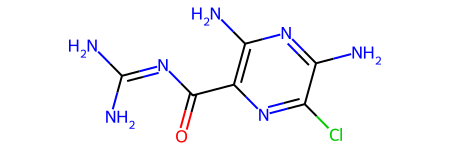

In [104]:
Chem.MolFromSmiles(samples_smiles[0])

In [105]:
similarity = calculate_scores(sampled_recs, sampled_recs, greedy_cs,is_symmetric=True).to_array()
similarity = np.vectorize(lambda x: x[0])(similarity)
print(similarity)

[[1.         0.99999917 0.55718412 0.55709531 0.67063451 0.70977158]
 [0.99999917 1.         0.55738841 0.55729957 0.67085325 0.71000912]
 [0.55718412 0.55738841 1.         0.99999948 0.83381229 0.84210363]
 [0.55709531 0.55729957 0.99999948 1.         0.8337442  0.84198826]
 [0.67063451 0.67085325 0.83381229 0.8337442  1.         0.97073928]
 [0.70977158 0.71000912 0.84210363 0.84198826 0.97073928 1.        ]]


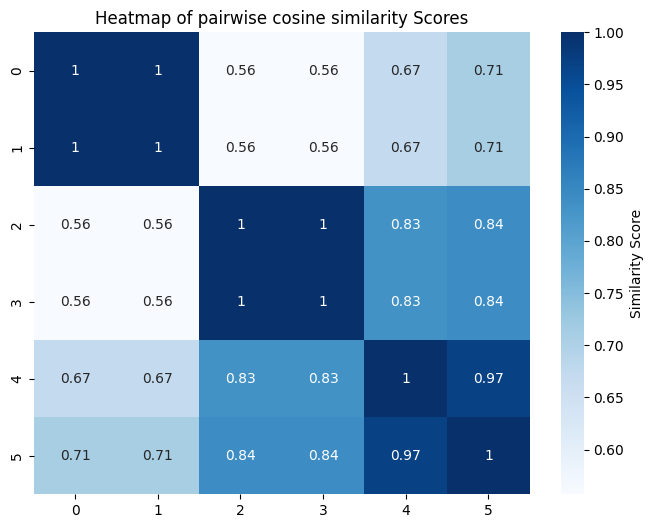

In [106]:

# Define labels for rows and columns
labels = ["Node 1", "Node 2", "Node 3", "Node 4"]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    similarity,
    annot=True,                # Show values in cells
    cmap="Blues",            # Ombre effect colormap
    cbar_kws={'label': 'Similarity Score'}  # Label for colorbar
)

# Add labels and title
plt.title("Heatmap of pairwise cosine similarity Scores")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

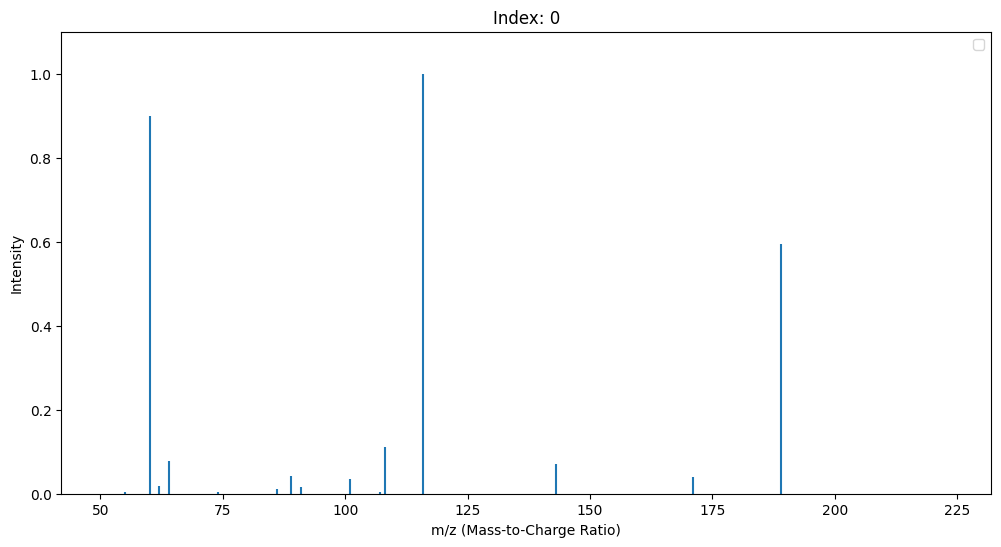

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

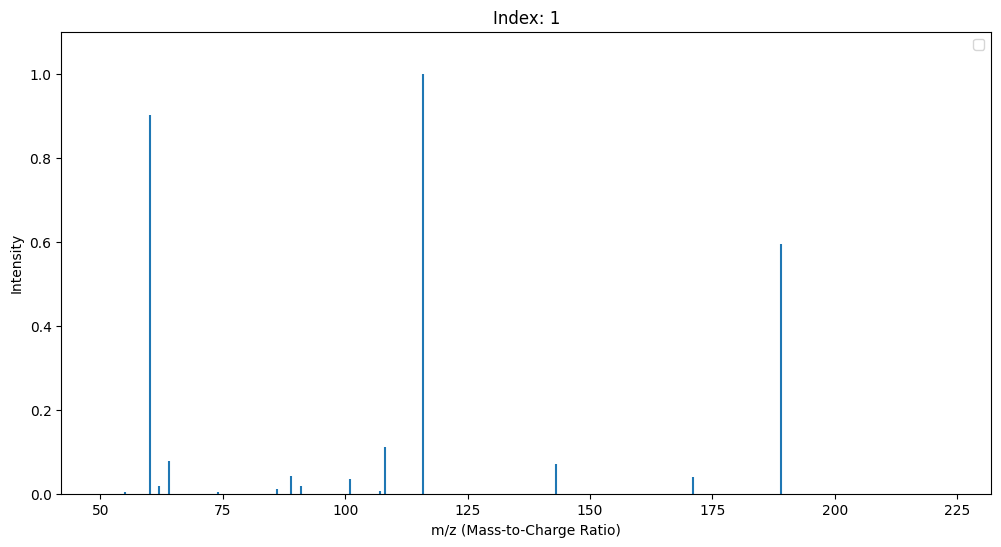

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

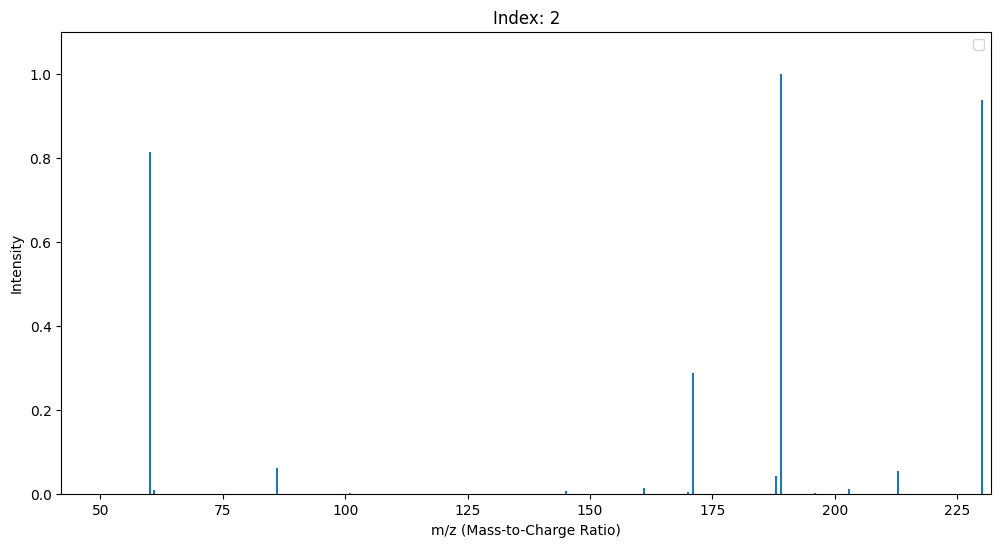

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

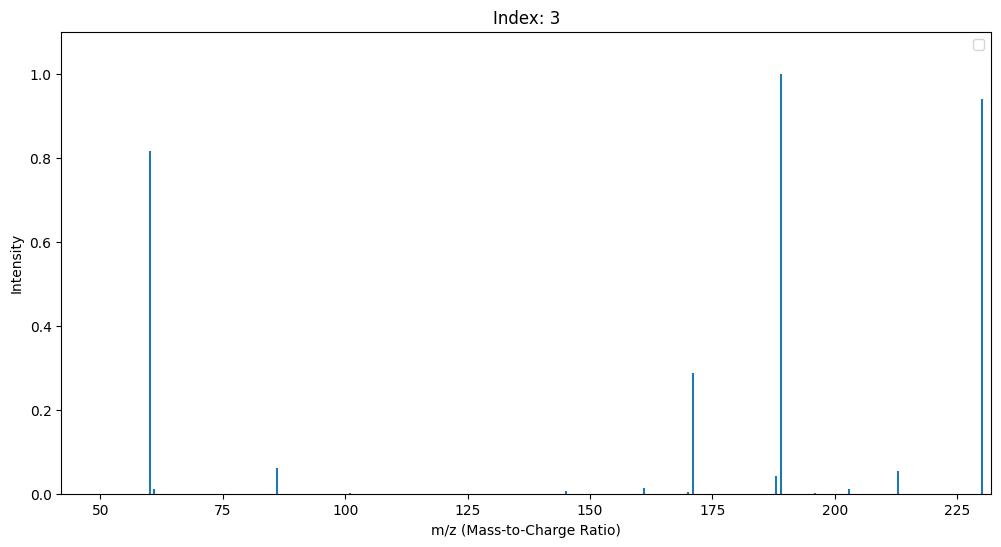

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

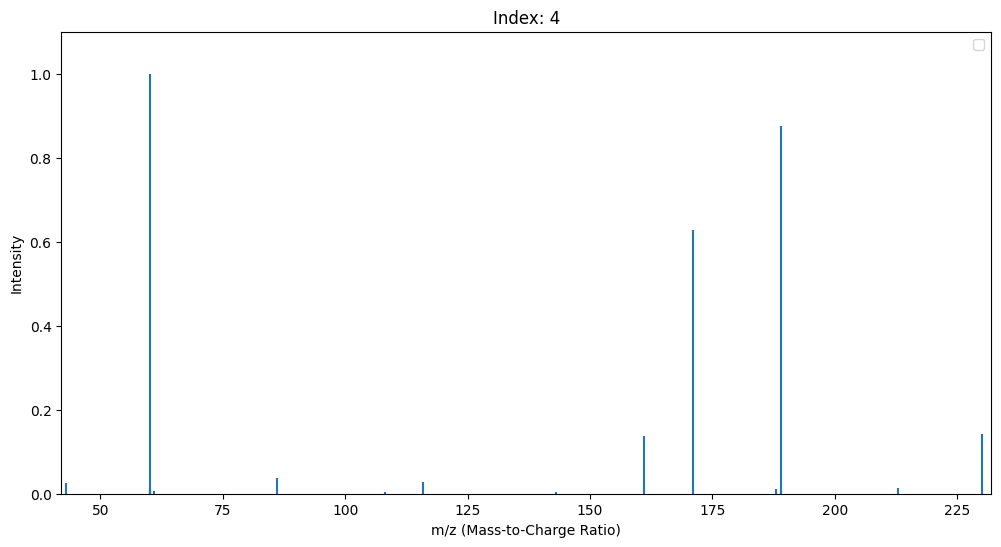

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

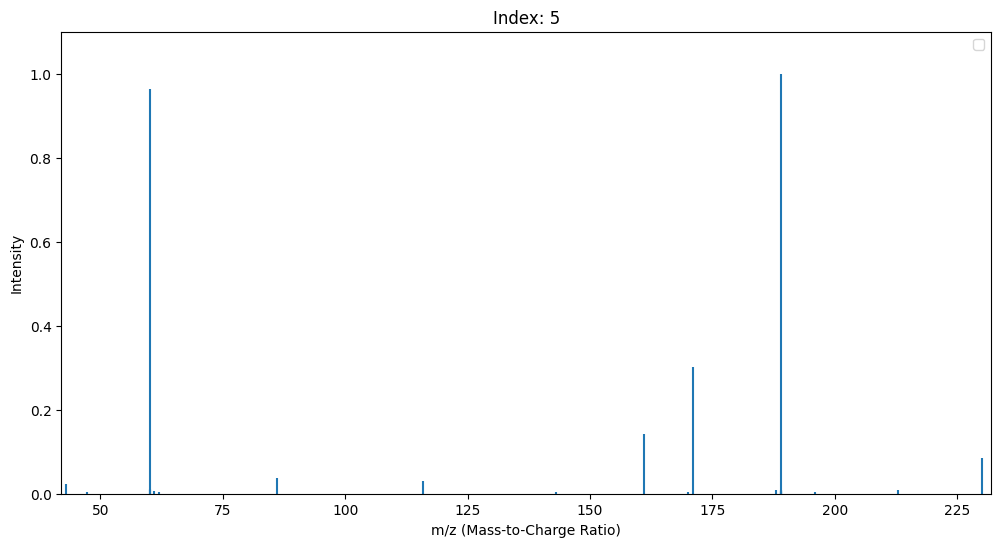

In [110]:
output_folder = "./plots/MS/example3"

if not os.path.exists(output_folder): os.makedirs(output_folder)
for i, r in enumerate(sampled_recs):

    id_ = r.metadata["identifier"]
    smiles = r.metadata["smiles"]
    precursor_mz = r.metadata["precursor_mz"]
    mz_values = r.mz
    intensity_values = r.intensities

    # Create the plot
    # Create the plot
    plt.figure(figsize=(14, 7))

    # Create the plot
    plt.figure(figsize=(12, 6))
    for mz, intensity in zip(mz_values, intensity_values):
        plt.vlines(x=mz, ymin=0, ymax=intensity, linewidth=1.5)

    # Add labels, title, and grid
    plt.xlim(42, 232)
    plt.ylim(0, 1.1)
    plt.xlabel("m/z (Mass-to-Charge Ratio)")
    plt.ylabel("Intensity")
    plt.title(f"Index: {i}")
    plt.legend()
    plt.savefig(os.path.join(output_folder, f"{i}.png"))
    plt.show()

In [26]:
smallest_mol, smallest_mass = [], 1000

for rec in tqdm(data):

    mass = rec.metadata["precursor_mz"]
    # if rec.metadata["instrument_type"] != 'Orbitrap':continue
    if mass < 200: continue
    if mass < smallest_mass:
        smallest_mass = mass 
        smallest_mol = []
    
    if mass == smallest_mass:
        smallest_mol.append(rec)

print(f"The smallest mass is: {smallest_mass}")

100%|██████████| 67736/67736 [00:03<00:00, 19591.04it/s]

The smallest mass is: 200.047276


Look at the smallest molecule

C1=CC(=CC=C1C[C@@H](C(=O)O)N)Cl MassSpecGymID0172260 Orbitrap
[(118.06506, 0.038), (119.07307, 0.205), (120.07668, 0.013999999999999999), (137.01562, 0.018000000000000002), (141.01009, 0.038), (154.04187, 1.0), (155.04555, 0.023), (165.01028, 0.039), (183.02095, 0.036000000000000004), (199.18822, 0.009000000000000001), (199.98938, 0.191), (200.04724, 0.057)]
C1=CC(=CC=C1C[C@@H](C(=O)O)N)Cl MassSpecGymID0172261 Orbitrap
[(118.06503, 0.031), (119.07288, 0.034), (137.01526, 0.013999999999999999), (141.01009, 0.035), (154.04173, 1.0), (165.01016, 0.042), (183.02055, 0.036000000000000004), (200.04729, 0.055)]
C1=CC(=CC=C1C[C@@H](C(=O)O)N)Cl MassSpecGymID0172262 QTOF
[(42.03439, 0.01), (51.02405, 0.006999999999999999), (65.03875, 0.012), (77.03898, 0.013000000000000001), (91.0576, 0.038), (91.07669, 0.01), (92.063, 0.013000000000000001), (104.05185, 0.037000000000000005), (113.02918, 0.017), (117.05732, 0.013000000000000001), (117.07032, 0.013999999999999999), (118.06545, 0.401), (118.07808,

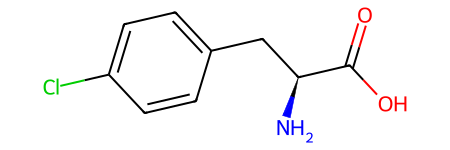

In [27]:
for small_mol in smallest_mol:
    print(small_mol.metadata["smiles"], small_mol.metadata["identifier"], small_mol.metadata["instrument_type"])
    print(list(zip(small_mol.mz, small_mol.intensities)))
    
Chem.MolFromSmiles(small_mol.metadata["smiles"])

Print the MS of the molecule

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

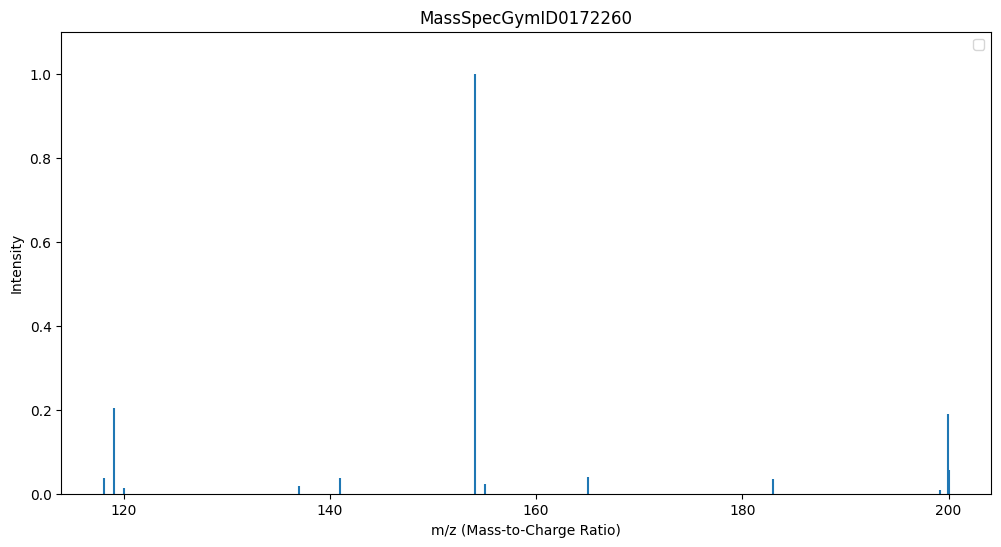

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

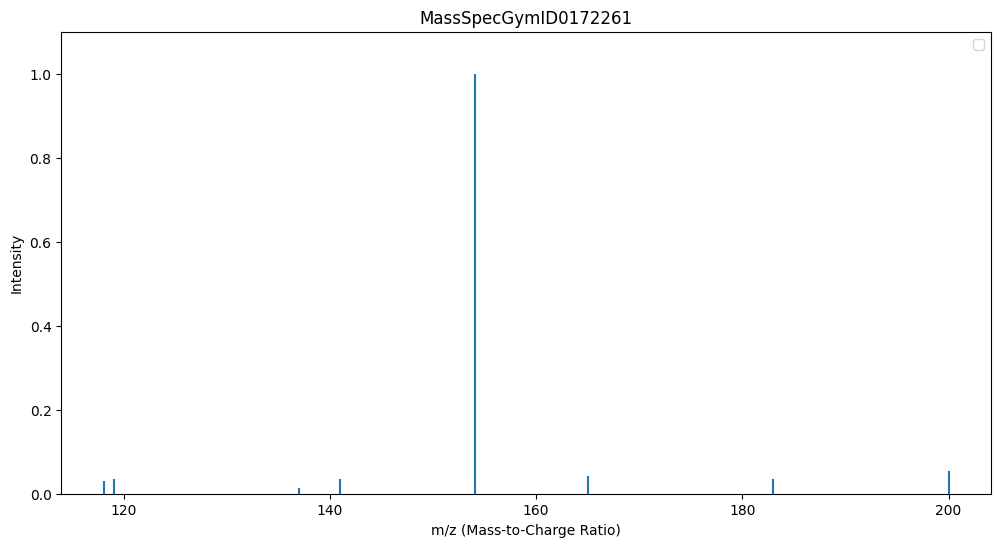

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

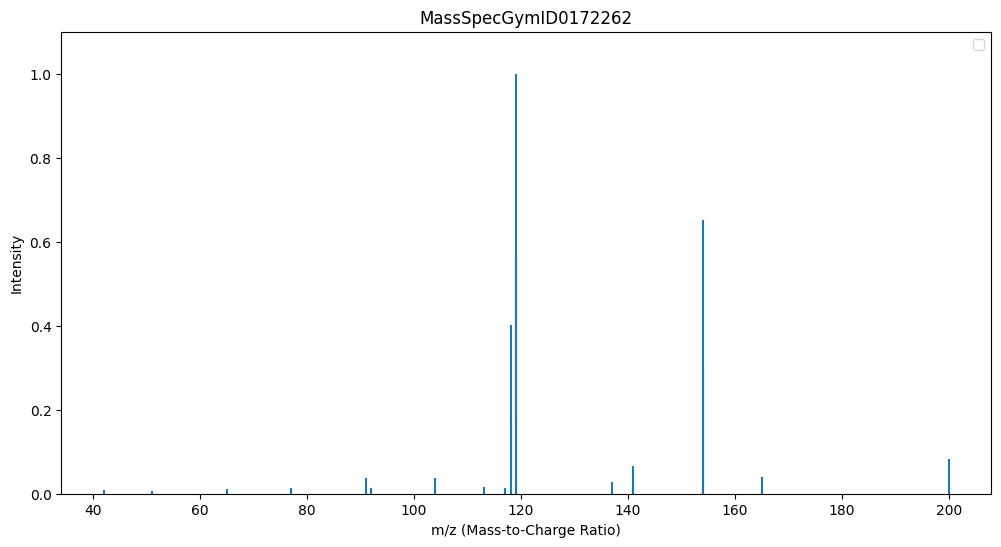

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

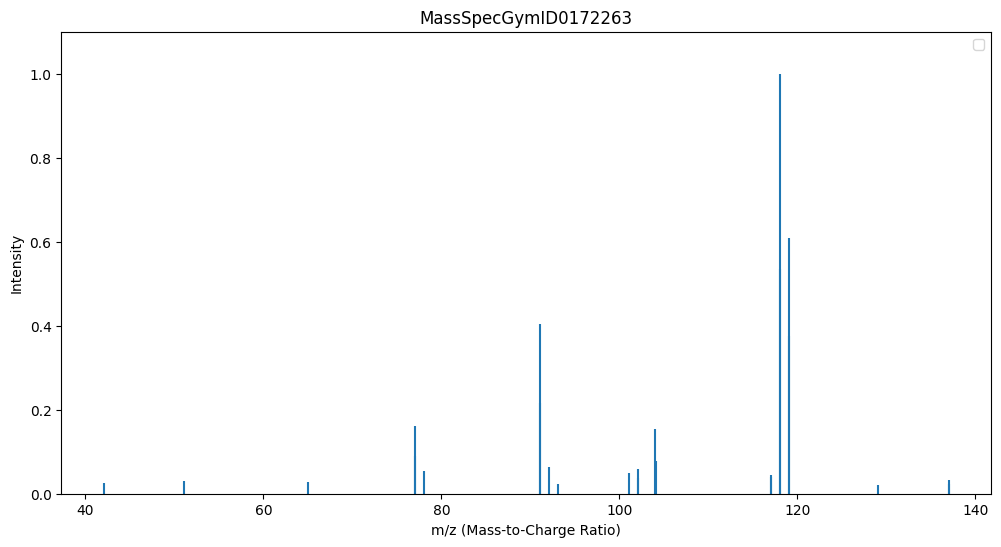

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

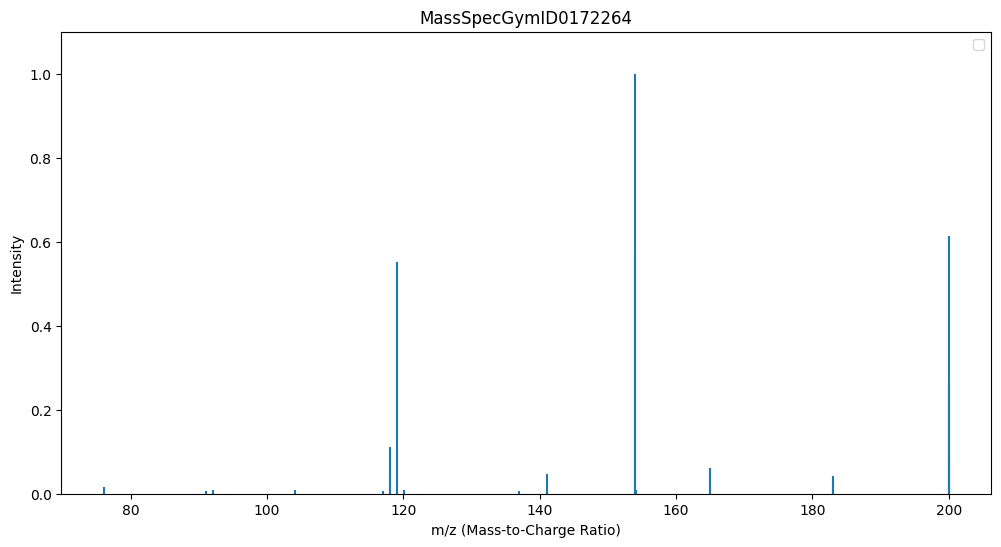

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

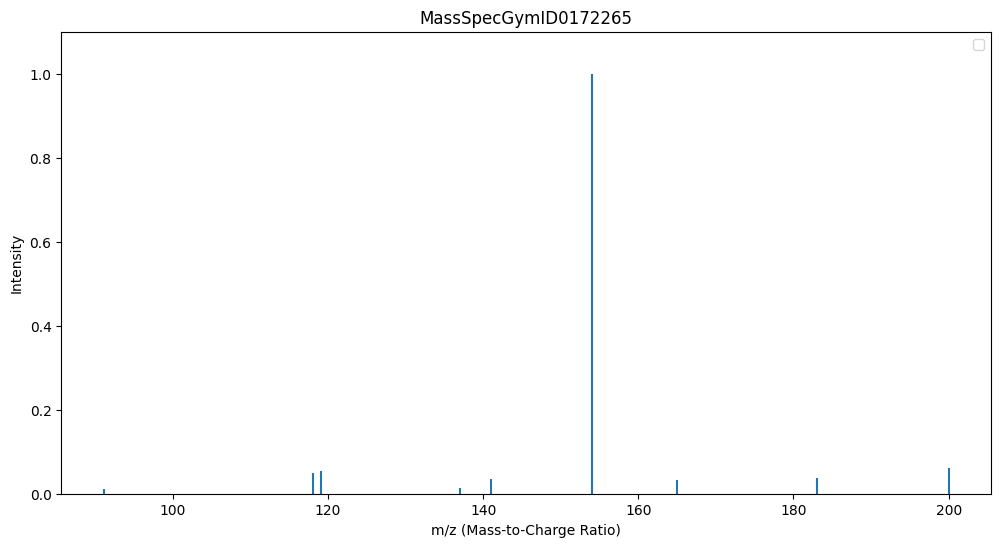

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

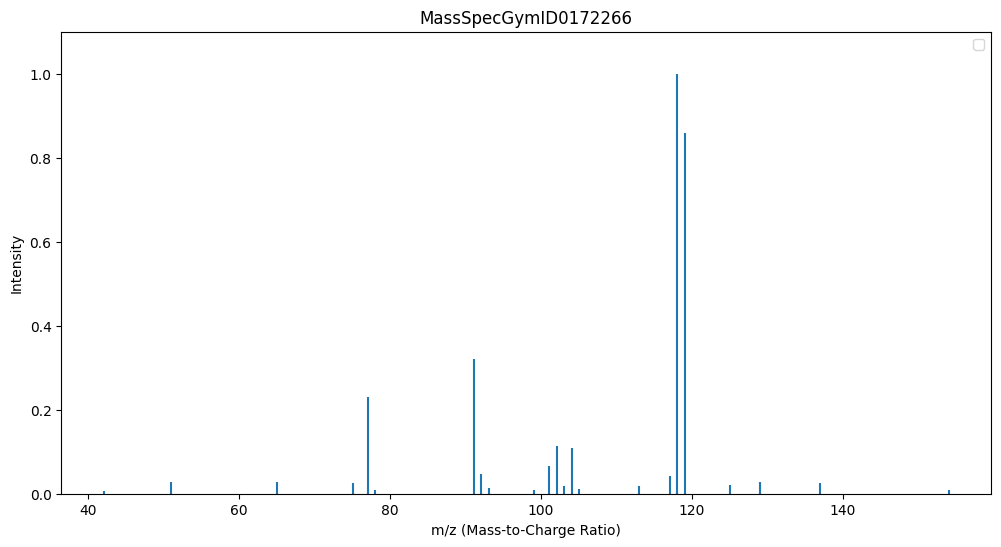

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x700 with 0 Axes>

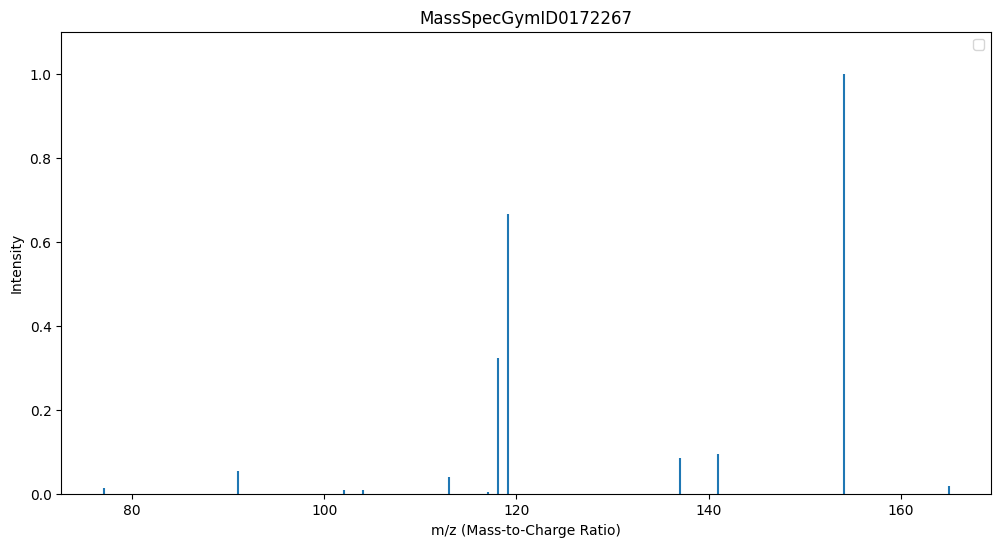

In [28]:
for small_mol in smallest_mol:

    id_ = small_mol.metadata["identifier"]
    smiles = small_mol.metadata["smiles"]
    precursor_mz = small_mol.metadata["precursor_mz"]
    mz_values = small_mol.mz
    intensity_values = small_mol.intensities

    # Create the plot
    # Create the plot
    plt.figure(figsize=(14, 7))

    # Create the plot
    plt.figure(figsize=(12, 6))
    for mz, intensity in zip(mz_values, intensity_values):
        plt.vlines(x=mz, ymin=0, ymax=intensity, linewidth=1.5)

    # Add labels, title, and grid
    plt.ylim(0, 1.1)
    plt.xlabel("m/z (Mass-to-Charge Ratio)")
    plt.ylabel("Intensity")
    plt.title(f"{id_}")
    plt.legend()
    plt.show()

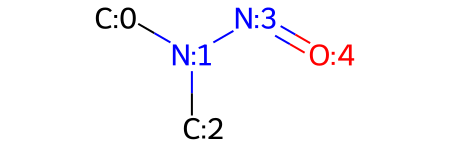

In [92]:

# Iterate over the atoms
for i, atom in enumerate(mol.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

mol


In [93]:
for small_mol in smallest_mol:

    mz = small_mol.mz
    intensities = small_mol.intensities
    smiles = small_mol.metadata["smiles"]
    machine_type = small_mol.metadata["instrument_type"]
    energy = small_mol.metadata["collision_energy"]

    mol = Chem.MolFromSmiles(smiles)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    bonds = [b for b in mol.GetBonds()]
    bonds_idx = [b.GetIdx() for b in bonds]
    mol_mass = Descriptors.ExactMolWt(mol) + 1.0078

    print(machine_type, energy)
    print([np.round(n, 2) for n in mz])
    print(intensities)
    print(f"Molecule {smiles}: Mass = {mol_mass:.4f} Da, Mass with H = {mol_mass + 1:.4f}")
    print() 

    for b in bonds_idx:

        frag_mol = Chem.FragmentOnBonds(mol, [b])
        frags = Chem.GetMolFrags(frag_mol, asMols=True, sanitizeFrags=True)

        print(bonds[b].GetBeginAtom().GetSymbol(), bonds[b].GetEndAtom().GetSymbol())
        # Calculate mass of each fragment
        for i, frag in enumerate(frags):
            mass = Descriptors.ExactMolWt(frag)
            mass_loss_H = mass - 1.0078
            smiles_frag = Chem.MolToSmiles(frag)  # Get SMILES for the fragment (optional)
            print(f"{i+1}: SMILES = {smiles_frag}, Mass = {mass:.4f} Da, Mass without H = {mass_loss_H:.4f}")
        
    print()

Orbitrap 30.0
[58.05, 75.06]
[0.01201201 1.        ]
Molecule CN(C)N=O: Mass = 75.0558 Da, Mass with H = 76.0558

C N
1: SMILES = [1*]C, Mass = 15.0235 Da, Mass without H = 14.0157
2: SMILES = *N(C)N=O, Mass = 59.0245 Da, Mass without H = 58.0167
N C
1: SMILES = [2*]N(C)N=O, Mass = 59.0245 Da, Mass without H = 58.0167
2: SMILES = [1*]C, Mass = 15.0235 Da, Mass without H = 14.0157
N N
1: SMILES = [3*]N(C)C, Mass = 44.0500 Da, Mass without H = 43.0422
2: SMILES = [1*]N=O, Mass = 29.9980 Da, Mass without H = 28.9902
N O
1: SMILES = [4*]=NN(C)C, Mass = 58.0531 Da, Mass without H = 57.0453
2: SMILES = [3*]=O, Mass = 15.9949 Da, Mass without H = 14.9871

Orbitrap 30.0
[58.05, 75.06]
[0.01245743 1.        ]
Molecule CN(C)N=O: Mass = 75.0558 Da, Mass with H = 76.0558

C N
1: SMILES = [1*]C, Mass = 15.0235 Da, Mass without H = 14.0157
2: SMILES = *N(C)N=O, Mass = 59.0245 Da, Mass without H = 58.0167
N C
1: SMILES = [2*]N(C)N=O, Mass = 59.0245 Da, Mass without H = 58.0167
2: SMILES = [1*]C, Mass

Group MS records

In [ ]:
i = 0 
for energy, current_data in data_repeated.items():
    for inchikey, current_data in current_data.items():
        for adduct, current_data in current_data.items():
            for instrument, rec_list in current_data.items():
                
                if len(rec_list) < 3: continue
                if i!= 0: 
                    print(energy, inchikey, adduct, instrument, rec_list[0].metadata["smiles"])
                
                    for rec in rec_list:
                        print(list(zip(rec.mz, rec.intensities)))
                
                    a = z

                i += 1

30.0 UQCSETXJXJTMKO [M+H]+ Orbitrap CC[C@H](C)[C@H]1C(=O)O[C@@H](C(=O)N([C@H](C(=O)O[C@@H](C(=O)N([C@H](C(=O)O[C@@H](C(=O)N1C)C(C)C)C(C)C)C)C(C)C)C(C)C)C)C(C)C
[(86.0964, 0.43843843843843844), (100.1121, 0.27427427427427425), (168.1383, 0.031031031031031032), (186.1489, 0.2952952952952953), (196.1332, 1.0), (200.1645, 0.16216216216216217), (210.1462, 0.5755755755755756), (214.1411, 0.6126126126126126), (228.1567, 0.26926926926926925), (314.1935, 0.30430430430430433), (328.2092, 0.1021021021021021)]
[(86.0964, 0.43922586), (100.1121, 0.27580526), (168.1383, 0.032213280000000004), (186.1489, 0.29636648), (196.1332, 1.0), (200.1645, 0.16383147), (210.1462, 0.57617239), (214.1411, 0.61328817), (228.1567, 0.27065876), (314.1935, 0.30510627), (328.2092, 0.10316167)]
[(86.096306, 0.12766), (100.111984, 0.07089000000000001), (168.138336, 0.01846), (182.154327, 0.01196), (186.148956, 0.12591), (196.133179, 1.0), (196.15007, 0.01973), (200.16449, 0.09288), (210.148972, 0.5856), (214.143845, 0.58

NameError: name 'z' is not defined

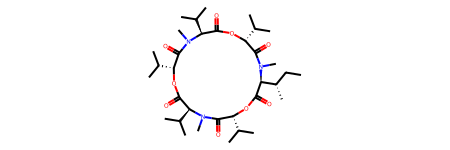

In [81]:
Chem.MolFromSmiles(rec_list[0].metadata["smiles"])

In [50]:
pattern = Chem.MolFromSmiles("C(CO)N")

for idx,rec in enumerate(data):

    mol = Chem.MolFromSmiles(rec.metadata["smiles"])
    check = mol.HasSubstructMatch(pattern)
    if check and idx not in [14,15,16]:
        print(idx)
        print(rec.metadata["smiles"])
        print(rec)
        a =z  



23
CC(C)C[C@H]1C(=O)O[C@@H](C(=O)N([C@H](C(=O)O[C@@H](C(=O)N([C@H](C(=O)O[C@@H](C(=O)N([C@H](C(=O)O[C@@H](C(=O)N1C)C(C)C)CC(C)C)C)C(C)C)CC(C)C)C)C(C)C)CC(C)C)C)C(C)C
Spectrum(precursor m/z=931.60, 3 fragments between 577.3 and 931.6)


NameError: name 'z' is not defined

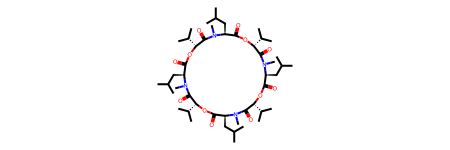

In [51]:
Chem.MolFromSmiles(rec.metadata["smiles"])

In [52]:
rec.mz

array([577.3486, 804.5008, 931.5978])

In [53]:
print(smallest_mol[0].metadata["precursor_mz"])
print(smallest_mol[0].metadata["formula"])
print(smallest_mol[0].mz)


62.0600395203
C2H7NO
[43.02824 44.04868 62.05976]


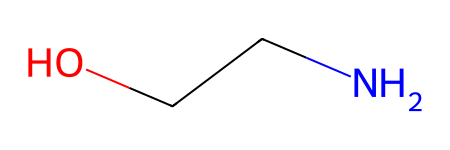

In [44]:
Chem.MolFromSmiles(smallest_mol[0].metadata["smiles"])